In [68]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier

from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

import os, sys
sys.path.append(os.path.abspath(".."))

seed = 42
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X : np.ndarray):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)

In [70]:
train_df = pd.read_csv("../../data/raw/data_raw.csv")

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 100 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               421 non-null    object 
 1   nose_x              421 non-null    float64
 2   nose_y              421 non-null    float64
 3   nose_z              421 non-null    float64
 4   left_eye_inner_x    421 non-null    float64
 5   left_eye_inner_y    421 non-null    float64
 6   left_eye_inner_z    421 non-null    float64
 7   left_eye_x          421 non-null    float64
 8   left_eye_y          421 non-null    float64
 9   left_eye_z          421 non-null    float64
 10  left_eye_outer_x    421 non-null    float64
 11  left_eye_outer_y    421 non-null    float64
 12  left_eye_outer_z    421 non-null    float64
 13  right_eye_inner_x   421 non-null    float64
 14  right_eye_inner_y   421 non-null    float64
 15  right_eye_inner_z   421 non-null    float64
 16  right_e

In [72]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x',
       'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y',
       'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y',
       'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y',
       'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z',
       'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z',
       'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y',
       'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z',
       'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y',
       'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z',
       'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x',
       'right_wrist_y', 'right_wrist_z', 'left_pinky_x', 'left_pinky_y

In [73]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,1_lie_on,0.210077,-0.237648,-0.260886,0.215173,-0.257125,-0.239805,0.219817,-0.255553,-0.239737,...,-0.058082,0.010227,0.298459,-0.077273,0.008661,0.368733,-0.168110,-0.023491,0.386474,-0.194409
1,1_lie_on,0.007859,-0.323530,-0.256766,0.022324,-0.349270,-0.234660,0.030838,-0.346419,-0.234611,...,0.082603,-0.018532,0.430020,0.054545,0.033470,0.442469,-0.035663,-0.046512,0.495238,-0.089421
2,1_lie_on,-0.173758,0.041498,-0.555332,-0.200457,0.017613,-0.536229,-0.202975,-0.000352,-0.536120,...,0.324744,0.375396,-0.134136,0.128405,0.289529,-0.217944,0.267827,0.447452,-0.161037,-0.003046
3,1_lie_on,0.124351,-0.109182,-0.203446,0.135755,-0.127358,-0.149985,0.144948,-0.125054,-0.150037,...,-0.346393,-0.332263,0.299014,-0.346069,-0.380637,0.367747,-0.501384,-0.344465,0.343337,-0.547637
4,1_lie_on,-0.024049,-0.169186,-0.388429,0.009905,-0.169294,-0.331276,0.027463,-0.162489,-0.330836,...,-0.012170,0.002502,0.411791,-0.126968,0.204579,0.460514,-0.189556,-0.002942,0.496046,-0.307282


<Axes: xlabel='label', ylabel='count'>

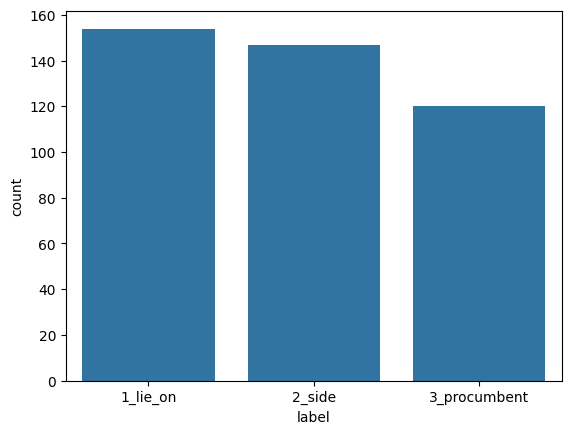

In [74]:
sns.countplot(x="label", data=train_df)

In [75]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [76]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [77]:
X_train.head()

,nose_x,nose_y,nose_z,left_eye_inner_x,left_eye_inner_y,left_eye_inner_z,left_eye_x,left_eye_y,left_eye_z,left_eye_outer_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,0.210077,-0.237648,-0.260886,0.215173,-0.257125,-0.239805,0.219817,-0.255553,-0.239737,0.224471,...,-0.058082,0.010227,0.298459,-0.077273,0.008661,0.368733,-0.168110,-0.023491,0.386474,-0.194409
1,0.007859,-0.323530,-0.256766,0.022324,-0.349270,-0.234660,0.030838,-0.346419,-0.234611,0.038493,...,0.082603,-0.018532,0.430020,0.054545,0.033470,0.442469,-0.035663,-0.046512,0.495238,-0.089421
2,-0.173758,0.041498,-0.555332,-0.200457,0.017613,-0.536229,-0.202975,-0.000352,-0.536120,-0.205464,...,0.324744,0.375396,-0.134136,0.128405,0.289529,-0.217944,0.267827,0.447452,-0.161037,-0.003046
3,0.124351,-0.109182,-0.203446,0.135755,-0.127358,-0.149985,0.144948,-0.125054,-0.150037,0.153637,...,-0.346393,-0.332263,0.299014,-0.346069,-0.380637,0.367747,-0.501384,-0.344465,0.343337,-0.547637
4,-0.024049,-0.169186,-0.388429,0.009905,-0.169294,-0.331276,0.027463,-0.162489,-0.330836,0.048154,...,-0.012170,0.002502,0.411791,-0.126968,0.204579,0.460514,-0.189556,-0.002942,0.496046,-0.307282


In [78]:
y_train

0      0
1      0
2      0
3      0
4      0
      ..
416    2
417    2
418    2
419    2
420    2
Name: label, Length: 421, dtype: int32

In [79]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [80]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[ 1.25214586, -0.87366703, -0.16940727, ..., -0.1437233 ,
         0.71778086, -0.58304324],
       [ 0.12925697, -1.47311192, -0.15369307, ..., -0.22736752,
         1.27195035, -0.38365115],
       [-0.87924106,  1.07473982, -1.29252809, ...,  1.56738383,
        -2.07188437, -0.21960706],
       ...,
       [ 1.08337396,  1.13041394, -0.22696854, ..., -1.48754848,
        -2.70376966,  0.18199365],
       [ 0.58898566, -0.80134717,  1.47584626, ..., -0.40902617,
         0.42159743, -0.02637853],
       [-1.03822613, -1.22370096,  1.76779869, ..., -1.17976568,
         0.69415392, -0.50601795]])

In [81]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [82]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [83]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


In [84]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,SVC,0.928739,0.928034
1,XGB,0.916863,0.917880
2,LR,0.912185,0.911829
3,RF,0.907451,0.908239
4,KNN,0.893081,0.891193
5,DTC,0.824174,0.826236


<Axes: xlabel='F1 score', ylabel='Model'>

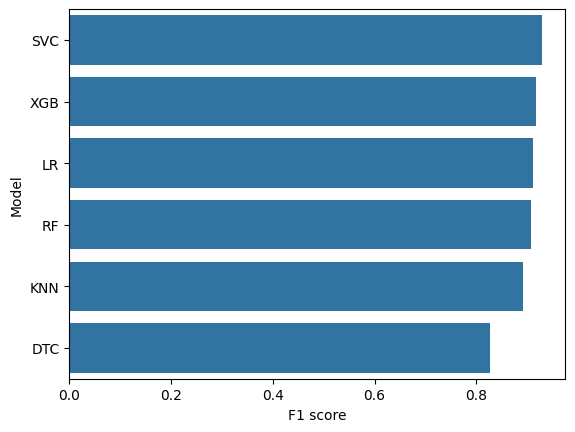

In [85]:
sns.barplot(x="F1 score", y="Model", data=print_results(results_before_tunning))

In [86]:
svc_best_model = SVC(probability=True, random_state=seed)

svc_best_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [87]:
accuracy = cross_val_score(svc_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(svc_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.9287394957983193,
 array([[148,   5,   1],
        [ 12, 127,   8],
        [  0,   4, 116]], dtype=int64))

<Axes: >

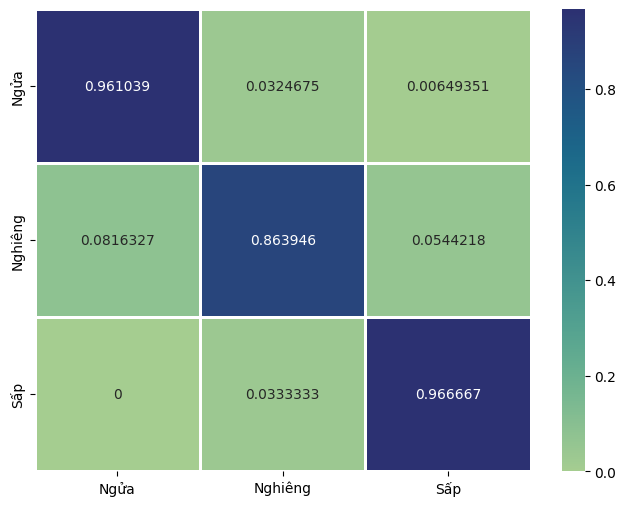

In [88]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["Ngửa", "Nghiêng", "Sấp"], columns=["Ngửa", "Nghiêng", "Sấp"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")